### CITS5508 labsheet 5

**Author: Alastair Mory (21120848)**<br>


In [1]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import pickle

# import other packages needed for the project below this line
import math
import random
from scipy import stats
import sklearn as sk
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import tensorflow.keras as keras

# Loading Dataset

In [2]:
# IMPOTRTANT: set the path where the data files are relative to the Notebook file. 
# You can change the variable pathname below to anything that suits you, For example,
# if your Notebook file is to be run on Google Colab, then you will need to set up
# this variable properly, e.g., 
#       pathname = os.path.join('My Drive', 'CITS5508').
#
# Before submitting your Notebook file to cssubmit, ensure that you change
# this variable back to '.'
pathname = '.'

RUNNING_IN_COLAB = False
if RUNNING_IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/lab5')
print(os.getcwd())
print(os.listdir('./'))

/home/alastair/Documents/CITS5508/ml-labs/lab5
['data_batch_5', 'test_batch', 'data_batch_2', 'lab05.ipynb', '.ipynb_checkpoints', 'readme.html', 'data_batch_1', 'batches.meta', 'data_batch_4', 'data_batch_3', 'lab05(1).ipynb']


In [3]:
# function for loading the data_batch_file
def load_pickle_file(filename, path='.'):
    '''
    This function reads the given pickle file and returns a dictionary object.
    '''
    with open(os.path.join(path,filename), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict  


def load_training(filename_prefix, N_batches, path='.', height=32, width=32, Nchannels=3):
    '''
    This function reads the 5 data batches and returns the X_train and y_train numpy arrays.
    To save memory space, X_train is set to 'float32' (single precision floating point numbers).
    If this causes an issue, it can be set to 'float64'. y_train is set to uint8. This is
    the same data type as used in the MNIST dataset, so it should be fine.
    '''
    batch_no = range(1,N_batches+1)  # the batch numbers start at 1
    # Read in the data_batch_ files
    batches = [load_pickle_file(filename_prefix+str(b), path=path) for b in batch_no]

    # variable batches is a list containing 5 elements, each of which is a dictionary object

    # compose our X_train and y_train
    # according to the download site, the training set should have 50,000 instances. We caldulate
    # the length from the dictionary that we read in anyway.
    batch_sizes = [len(batches[i][b'labels']) for i in range(N_batches)]
    train_set_size = np.sum(batch_sizes)
    
    X_train = np.zeros((train_set_size, width, height, Nchannels), dtype='float32')
    y_train = np.zeros(train_set_size).astype('uint8')
    loc = 0
    for i in range(N_batches):
        X_train[loc:(loc+batch_sizes[i]),:,:,:] = np.rollaxis(
            np.reshape(batches[i][b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
        y_train[loc:(loc+batch_sizes[i])] = batches[i][b'labels']
        loc += batch_sizes[i]
    return X_train, y_train


def load_testing(filename, path='.', height=32, width=32, Nchannels=3):
    '''
    This function reads the test_batch and returns X_test and y_test.
    To save memory space, X_test is set to 'float32' (single precision floating point numbers).
    If this causes an issue, it can be set to 'float64'. y_test is set to uint8. This is
    the same data type as used in the MNIST dataset, so it should be fine.
    '''
    # now read test_batch and construct the test set
    test_dict = load_pickle_file(filename, path=path)
    
    X_test = np.rollaxis(np.reshape(test_dict[b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
    X_test = X_test.astype('float32')
    y_test = np.array(test_dict[b'labels'], dtype='uint8')
    return X_test, y_test

In [4]:
# According to the download site, the training set is split into five batches stored in 5 files,
# each colour image has dimension equal to 32 x 32 x 3, and there are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

N_batches = 5  
train_filename_prefix = 'data_batch_'
test_filename = 'test_batch'

X_train, y_train = load_training(train_filename_prefix, N_batches, path=pathname)
X_test, y_test = load_testing(test_filename, path=pathname)

# MLP Network

## Hyperparameters



### Connection weight initialisation

The two connection weights tested were [Glorot Uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform) (the Keras dense layer default) and [Random Normal](https://www.tensorflow.org/api_docs/python/tf/random_normal_initializer) with default arguments. No difference in accuracy was found between the two.

Glorot Uniform selects weights from a random uniform distribution of $[-limit, limit]$ where:

$limit = \sqrt{6/(fan_{in} + fan_{out})}$

$fan_{in}$ and $fan_{out}$ are the number of input and output connections for the relevant layer. This corresponds to a $limit$ of 0.0425 and 0.125 for the first and second layers of our MLP network respectively.

Random Normal selects weights from a random normal distribution with a default $\mu=0$ and $\sigma=0.05$.

For the layer sizes used in our MLP network the distribution of weights produced by each initialiser are not that different (see visual comparison below), as such it's unsurprising that both result in networks that have the same accuracy after training.

![cwi distribution comparison](https://i.imgur.com/QxkpVA8.png)
<h7><center>Figure 1: Connection weight initialiser probability distributions</center></h7>


### Learning rate scheduling

The MLP network was tested with the default Keras learning rate of 0.01, and again with a lower learning rate of 0.001. The default performed best, with accuracy on the validation set roughly 5% better than the lower learning rate after 10 epochs (see learning history graph below)


![learning rate scheduling graph](https://i.imgur.com/0d11lgj.png)
<h7><center>Figure 2: Learning rate training history comparison</center></h7>

Other learning rates from 0.00025 to 0.25 where experimented with. Those below 0.01 had slower accuracy improvements of the epochs, while those above 0.01 did not tend to train any faster than the default, in fact they tended to overfit with large divergences between the training and validation accuracies. At learning rates on the order of 0.25 the model diverged, performing no better than random guesses.


### Early stopping

Early stopping was implemented using validation loss with a patience of 3 so that training would terminate after 3 epochs with no decrease in the validation loss. When the model was trained with early stopping and other relatively optimal hyperparameters early stopping rarely occured within 10 epochs. However when training with hyperarameters that caused the model to diverge (e.g. a learning rate above 0.2, connection weights initalised to zero, or poorly selected activation functions or optimizer) training would usually terminate by epoch four or five.

## Architecture

The MLP network has a relatively simple layout, with two dense hidden fully-connected layers between an input flatterning layer and a ten unit output layer. 

In [5]:
cwi = 'glorot_uniform'  # connection weight initialiser, default 'glorot_uniform'.
es = False  # Whether to perform early stopping or not
lrs = None  # learning rate scheduling: lambda expression or constant, default: None=0.01

# Configure MLP Model Layers
mlp_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(256, activation='relu', kernel_initializer=cwi),
    keras.layers.Dense(128, activation='relu', kernel_initializer=cwi),
    keras.layers.Dense(10, activation='linear', kernel_initializer=cwi)
])

# callbacks to perform early stopping or learning rate scheduling.
callbacks = []
if es:
    callbacks.append(keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True))
if lrs:
    scheduler = lambda e, r: lrs
    callbacks.append(keras.callbacks.LearningRateScheduler(scheduler))

# Compile model and show summary
mlp_model.compile(optimizer='sgd',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


## Training and Testing

In [6]:
print("Training MLP network:")
mlp_history = mlp_model.fit(X_train, y_train, epochs=10, callbacks=callbacks, validation_split=0.2,
                            batch_size=32)
print(f"Accuracy: {mlp_model.evaluate(X_test, y_test, verbose=0)[1]:.4f}\n")
mlp_y_pred  = np.array([np.argmax(x) for x in mlp_model.predict(X_test)]) 

Training MLP network:
Epoch 1/10
1250/1250 [==============================] - 12s 9ms/step - loss: 1.9085 - accuracy: 0.3167 - val_loss: 1.8049 - val_accuracy: 0.3556
Epoch 2/10
1250/1250 [==============================] - 12s 9ms/step - loss: 1.7253 - accuracy: 0.3882 - val_loss: 1.6866 - val_accuracy: 0.4059
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.6458 - accuracy: 0.4194 - val_loss: 1.6524 - val_accuracy: 0.4143
Epoch 4/10
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5891 - accuracy: 0.4389 - val_loss: 1.5963 - val_accuracy: 0.4367
Epoch 5/10
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5451 - accuracy: 0.4520 - val_loss: 1.5988 - val_accuracy: 0.4365
Epoch 6/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.5088 - accuracy: 0.4672 - val_loss: 1.5327 - val_accuracy: 0.4592
Epoch 7/10
1250/1250 [==============================] - 13s 10ms/step - loss: 1.4808 - accuracy: 0.4781 

## Classification Results

The MLP network achieves an accuracy of roughly 48%. Detailed metrics (including per-class and overall precision, recall and f1 scores) are listed in the table below. The precision for a class gives the correct predictions of that class as a proportion of the total predictions for that class ($\frac{TP}{TP+FP}$), while recall gives the correct predictions of a class as a proportion of the total occurences of that class ($\frac{TP}{TP+FN}$), the f1 score is the mean of precision and recall. We can find the biases in our model by observing the ratio of recall to precision, classes with high recall but low precision tend to be overpredicted, while those with low recall but high precision tend to be under represented in the model's predictions.

In [7]:
print("Per class precision and recall metrics:")
print(sk.metrics.classification_report(y_test, mlp_y_pred, target_names=class_names))

Per class precision and recall metrics:
              precision    recall  f1-score   support

    airplane       0.54      0.50      0.52      1000
  automobile       0.61      0.57      0.59      1000
        bird       0.44      0.21      0.29      1000
         cat       0.35      0.35      0.35      1000
        deer       0.43      0.47      0.45      1000
         dog       0.43      0.33      0.37      1000
        frog       0.51      0.54      0.53      1000
       horse       0.58      0.49      0.53      1000
        ship       0.49      0.72      0.59      1000
       truck       0.46      0.65      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



### Confusion matrix

Below is the confusion matrix for the MLP network's predictions. Some commonly confused classes include automobiles and trucks as well as cats and dogs. There is a 6x6 square of slightly darker blues in the center of the confusion matrix corresponding to the animal classes, showing animals are more likely to be mispredicted as another animal than a vehicle, the inverse is also true with the corners (corresponding to vehicles confused for other vehicles) also having slightly darker shading.

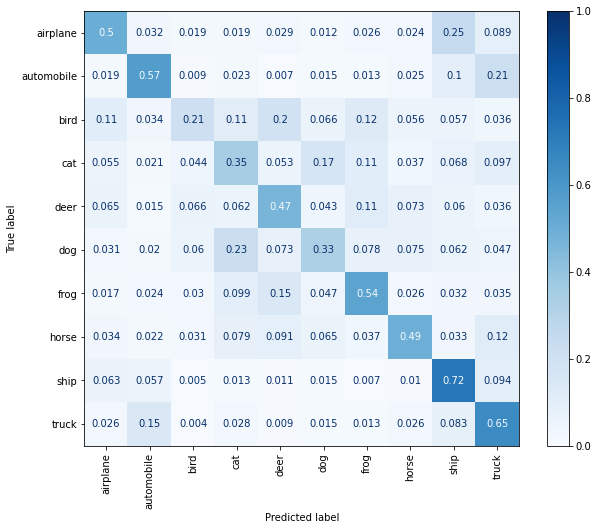

In [8]:
def plot_confusion_matrix(y_true, y_pred,
                          display_labels=class_names,
                          xticks_rotation='vertical',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(1, figsize=(10,8))
    disp.plot(cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)
    # set limit of the colorbar [0,1]
    disp.im_.set_clim(0, 1)

plot_confusion_matrix(y_test, mlp_y_pred)

### Prediction samples

Below are ten randomly selected examples of correctly classified images and ten randomly selected examples of misclassified images.

10 randomly selected correctly predicted images


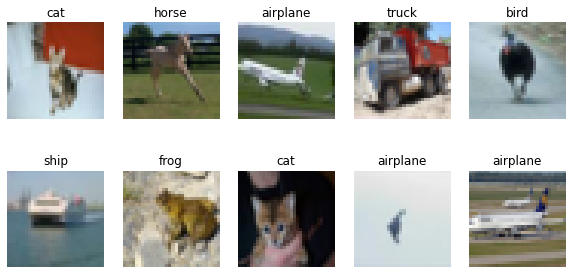

10 randomly selected incorrectly predicted images


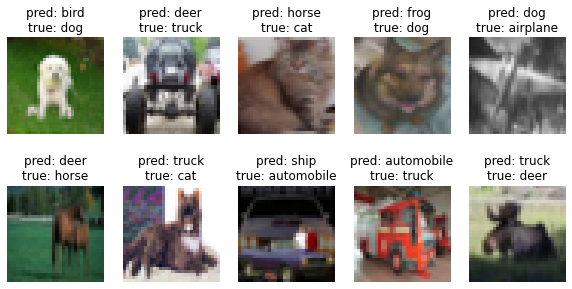

In [9]:
def get_rand_image_pred(x, y_true, y_pred, correct=True):
    i = random.randint(0,len(x)-1)
    if (y_true[i] == y_pred[i]) == correct:
        return (x[i], y_true[i], y_pred[i])
    else:
        return get_rand_image_pred(x, y_true, y_pred, correct)

def plot_sample_images(X_test, y_test, y_pred,
                       correct=True, rows=2, cols=5, figsize=(10,5)):
    correctly = "correctly" if correct else "incorrectly"
    print(f"{rows * cols} randomly selected {correctly} predicted images")
    plt.figure(figsize=figsize)
    for i in range(rows * cols):
        image, tclass, pclass = get_rand_image_pred(X_test, y_test, y_pred, correct)
        ax = plt.subplot(rows,cols,i+1)
        plt.imshow(image)
        plt.axis('off')
        if correct:
            ax.set_title(f"{class_names[pclass]}")
        else:
            ax.set_title(f"pred: {class_names[pclass]}\ntrue: {class_names[tclass]}")
    plt.show()


plot_sample_images(X_test, y_test, mlp_y_pred, correct=True)
plot_sample_images(X_test, y_test, mlp_y_pred, correct=False)

# CNN


## CNN Hyperparameters

### Kernel size

Kernel sizes of two and four were tried, both reached similar accuracies at around seventy percent, however a kernel size of four reached this level of accuracy in approximately half the number of training epochs.

### Number of kernels (filters)

In this CNN the second convolutional layer has twice as many kernels / filters as the first (due to the dimensionality reduction that occurs between the two layers and the way higher level features combine it's to double the number of filters after each layer). CNNs with 64 and 128 as well as 256 and 512 filters for the first and second convulotuional layers were tested, with the CNN containing more filters requiring four times the training time per epoch (which was expected as there were roughly four times the training parameters). Both CNNs reached the same level of accuracy, however the CNN with more filters reaching an accuracy of ~70% in approximately half the epochs as the CNN with less.

### Dropout rate

Experiments with no dropout, and a dropout rate of one half immediately prior to the output layer were tried. No significant difference in accuracy between the two was observed. However the there was a smaller difference between the training and validation accuracies when dropout was used, suggesting the model was better able to generalise predictions in that case.

### Activation function

The CNN was tested with two different activation functions in the convolutional layers, ReLU and linear. The model performed better with using the ReLU activation function, achieving an accuracy almost ten percent higher than with a linear activation function.

## Architecture

The CNN uses a model with a few more layers than the MLP network, with two convolutional 2D - max pooling 2D layer pairs in series, followed by a flatterning layer, a dropout layer and finally the dense 10 unit output layer.

In [10]:
RETRAIN_MODEL = True
checkpoint_filepath = './Mory_Alastair'

kernels = 64
kernel_size = 4
dropout_rate = 0.5
activation_function = 'relu'

conv_args = {
    'kernel_size': kernel_size,
    'activation': activation_function,
    'padding': 'same'
}

cnn_model = keras.Sequential([
    keras.layers.Conv2D(kernels, **conv_args, input_shape=(32, 32, 3)),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(kernels * 2, **conv_args),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(10, activation='linear')
])

cnn_model.summary()

cnn_model.compile(optimizer='rmsprop',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True))

if not RETRAIN_MODEL:
    cnn_model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               


## Training and Testing

In [11]:
print("Training MLP network:")
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, callbacks=callbacks, validation_split=0.2,
                            batch_size=64)
cnn_y_pred = np.array([np.argmax(x) for x in cnn_model.predict(X_test)])
print(f"Accuracy: {cnn_model.evaluate(X_test,y_test,verbose=0)[1]:.4f}")

Training MLP network:
Epoch 1/10
210/625 [=========>....................] - ETA: 3:14 - loss: 1.8715 - accuracy: 0.3279

KeyboardInterrupt: 

## Classification Results



Our MLP network achieves a percentage accuracy in the low 70's. Detailed metrics (including per-class and overall precision, recall and f1 scores) are listed in the table below. 

In [78]:
print("Per class precision and recall metrics:")
print(sk.metrics.classification_report(y_test, cnn_y_pred, target_names=class_names))

Per class precision and recall metrics:
              precision    recall  f1-score   support

    airplane       0.69      0.83      0.75      1000
  automobile       0.80      0.87      0.83      1000
        bird       0.68      0.56      0.61      1000
         cat       0.58      0.50      0.54      1000
        deer       0.70      0.62      0.66      1000
         dog       0.60      0.67      0.64      1000
        frog       0.71      0.84      0.77      1000
       horse       0.82      0.72      0.77      1000
        ship       0.88      0.79      0.83      1000
       truck       0.76      0.81      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



### Confusion Matrix

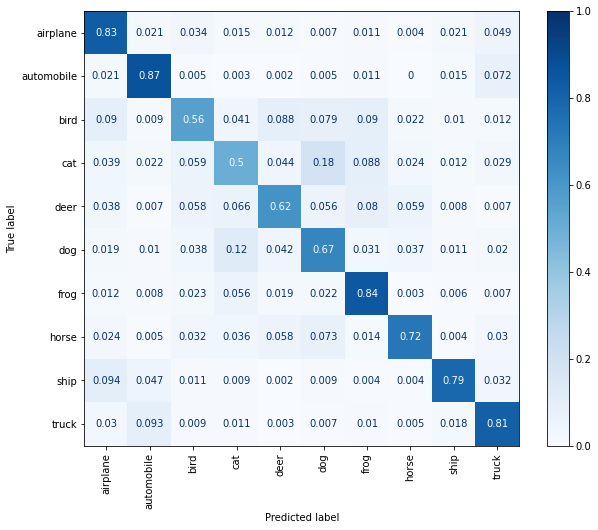

In [79]:
plot_confusion_matrix(y_test, cnn_y_pred,)

### Sample predictions

Below are ten randomly selected examples of correctly classified images and ten randomly selected examples of misclassified images.

10 randomly selected correctly predicted images


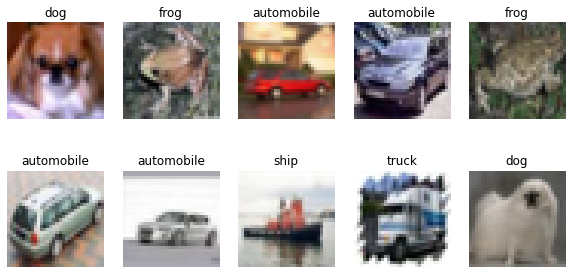

10 randomly selected incorrectly predicted images


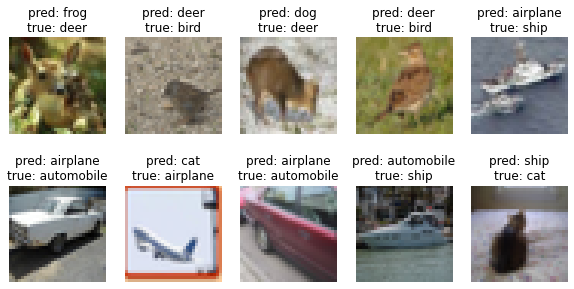

In [80]:
plot_sample_images(X_test, y_test, cnn_y_pred, correct=True)
plot_sample_images(X_test, y_test, cnn_y_pred, correct=False)

# Comparison

The multilayer perceptron network reaches a prediction accuracy of around 47%, while the convolutional neural network's accuracy is about 72%. This means the MLP network makes almost twice as many classification errors as the CNN. While the CNN does perform significantly better than the MLP network, it does take much longer to train (around 2.5X more time or 10s per epoch vs. 2-3s).

## Confusion Matrices

When viewing the confusion matrices for each model's predictions side by side (and ensuring both use the same colour scale), it is clear the CNN has much better performance than the MLP network. Recall for some classes reach as high as 90% for the CNN with maximum class recall topping out around 70% in the MLP's case.

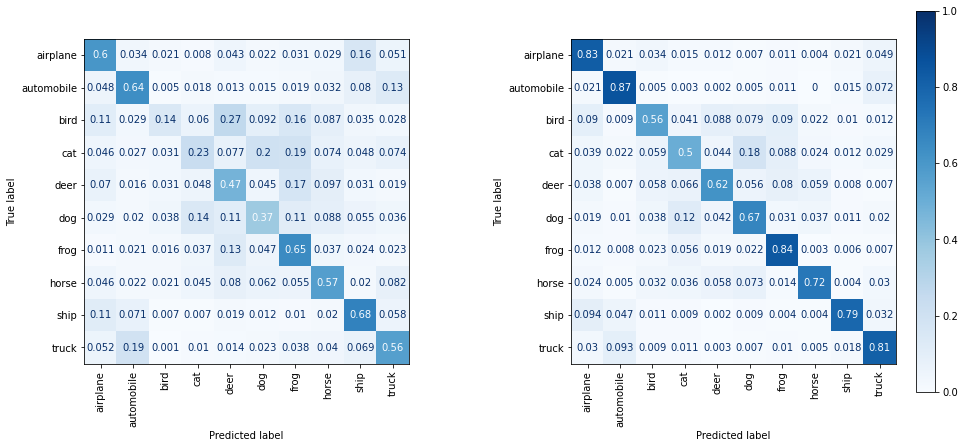

In [81]:
def plot_confusion_matrix(y_true, mlp_y_pred, cnn_y_pred,
                          display_labels=class_names,
                          xticks_rotation='vertical',
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(ncols=2, figsize=(16,7))
    mlp_cm = confusion_matrix(y_true, mlp_y_pred, normalize='true')
    mlp_disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=display_labels)
    mlp_disp.plot(cmap=cmap, ax=ax[0], xticks_rotation=xticks_rotation)
    cnn_cm = confusion_matrix(y_true, cnn_y_pred, normalize='true')
    cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=display_labels)
    cnn_disp.plot(cmap=cmap, ax=ax[1], xticks_rotation=xticks_rotation)
    # set limit of the colorbar
    mlp_disp.im_.set_clim(0, 1)
    cnn_disp.im_.set_clim(0, 1)
    # remove the colorbar
    mlp_disp.im_.colorbar.remove()

plot_confusion_matrix(y_test, mlp_y_pred, cnn_y_pred)

## Training History

Below are graphs of the per epoch training and validation set loss function value and accuracy, showing how the models performance improves over training iterations. From the shape of the curves it appears both models' training begins to reach a point of diminishing returns around epoch ten.

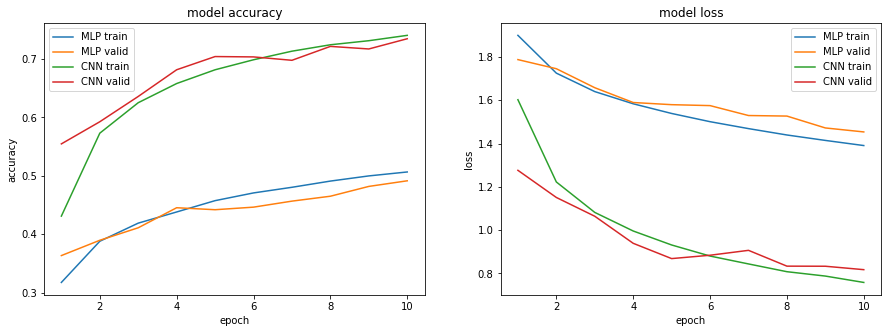

In [82]:
def plot_history():
    fig, ax = plt.subplots(ncols=2,figsize=(15, 5))
    ax1, ax2 = ax
    x = np.arange(1, 11)

    # summarize history for accuracy  
    ax1.plot(x, mlp_history.history['accuracy'])  
    ax1.plot(x, mlp_history.history['val_accuracy'])  
    ax1.plot(x, cnn_history.history['accuracy'])  
    ax1.plot(x, cnn_history.history['val_accuracy'])  
    ax1.set_title('model accuracy')  
    ax1.set_ylabel('accuracy')  
    ax1.set_xlabel('epoch')  
    ax1.legend(['MLP train', 'MLP valid', 'CNN train', 'CNN valid'], loc='upper left')  
    
    # summarize history for loss  
    ax2.plot(x, mlp_history.history['loss'])  
    ax2.plot(x, mlp_history.history['val_loss'])  
    ax2.plot(x, cnn_history.history['loss'])  
    ax2.plot(x, cnn_history.history['val_loss'])  
    ax2.set_title('model loss')  
    ax2.set_ylabel('loss')  
    ax2.set_xlabel('epoch')  
    ax2.legend(['MLP train', 'MLP valid', 'CNN train', 'CNN valid'], loc='upper right')  

plot_history()

## Model Architecture

Below are the summaries of the layer architectures of both networks. The MLP network has fewer layers and less perceptrons than the CNN, however it has more trainable parameters because each layer is fully connected. The CNN is a deeper network with more types of layers (making it slower to train), however there are fewer trainable parameters due to the local connectivity of the convolutional layers.

Both models used the same optimiser (stochastic gradient descent) and loss function (sparse categorical cross entropy) and were trained for ten epochs each, however the CNN network used a batch size twice that of the MLP network to improve training speed (64 vs 32).

In [83]:
print("Multi layer perceptron network architecture:")
mlp_model.summary()
print("\nConvolutional neural network architecture:")
cnn_model.summary()

Multi layer perceptron network architecture:
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________

Convolutional neural network architecture:
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c

# Appendix

## Code used to plot figures

### Figure 1: Connection weight initialiser probability distribution

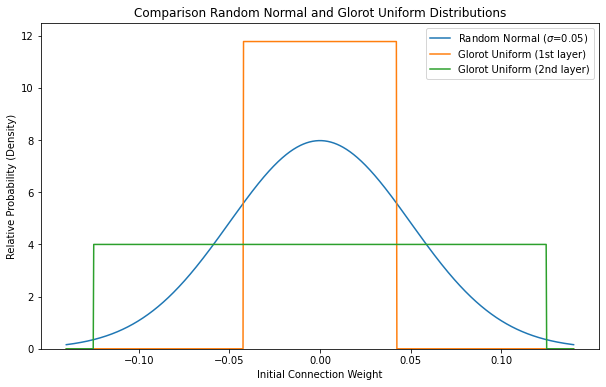

In [84]:
def plot_cwi_density():
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.linspace(-.14, .14, 1000)

    # Normal PDF, std = 0.05
    ax.plot(x, stats.norm.pdf(x, 0, 0.05))

    # Glorot Uniform layer 1
    fan1 = 32 * 32 * 3 +256
    limit1 = math.sqrt(6/fan1)
    u1 = lambda x: 0.5/limit1 if -limit1 < x < limit1 else 0
    ax.plot(x, [u1(xi) for xi in x])

    # Glorot Uniform layer2
    fan2 = 256 + 128
    limit2 = math.sqrt(6/fan2)
    u2 = lambda x: 0.5/limit2 if -limit2 < x < limit2 else 0
    ax.plot(x, [u2(xi) for xi in x])


    ax.legend(['Random Normal ($\sigma$=0.05)', 'Glorot Uniform (1st layer)', 'Glorot Uniform (2nd layer)'])
    ax.set_title('Comparison Random Normal and Glorot Uniform Distributions')
    ax.set_ylim(0, 12.5)
    ax.set_ylabel("Relative Probability (Density)")
    ax.set_xticks([-.1, -.05, 0, .05, .1])
    ax.set_xlabel("Initial Connection Weight")
    plt.show()

plot_cwi_density()

### Figure 2: Learning rate schedule training history

learning rate: 0.01
Epoch 1/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.9071 - accuracy: 0.3193 - val_loss: 1.8034 - val_accuracy: 0.3587
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7171 - accuracy: 0.3916 - val_loss: 1.7128 - val_accuracy: 0.3898
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6359 - accuracy: 0.4212 - val_loss: 1.6334 - val_accuracy: 0.4204
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5820 - accuracy: 0.4416 - val_loss: 1.5952 - val_accuracy: 0.4419
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5378 - accuracy: 0.4535 - val_loss: 1.5603 - val_accuracy: 0.4435
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5015 - accuracy: 0.4704 - val_loss: 1.5384 - val_accuracy: 0.4606
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4700 - accuracy: 0.4820 - val_loss: 1.

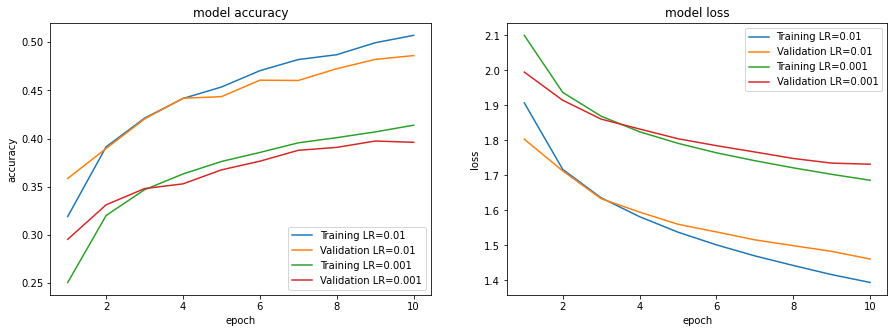

In [85]:


def plot_learning_rate_training_history():
    model_01 = keras.Sequential([
        keras.layers.Flatten(input_shape=(32, 32, 3)),
        keras.layers.Dense(256, activation='relu', kernel_initializer=cwi),
        keras.layers.Dense(128, activation='relu', kernel_initializer=cwi),
        keras.layers.Dense(10, activation='linear', kernel_initializer=cwi)
    ])
    model_01.compile(optimizer='sgd',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    print("learning rate: 0.01")
    mlp_01_history = model_01.fit(X_train, y_train, epochs=10, validation_split=0.2)
    model_001 = keras.Sequential([
        keras.layers.Flatten(input_shape=(32, 32, 3)),
        keras.layers.Dense(256, activation='relu', kernel_initializer=cwi),
        keras.layers.Dense(128, activation='relu', kernel_initializer=cwi),
        keras.layers.Dense(10, activation='linear', kernel_initializer=cwi)
    ])
    model_001.compile(optimizer='sgd',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    print("learning rate: 0.001")
    scheduler = lambda e, r: 0.001  # if e < 2 else r * 0.9
    schedule = [keras.callbacks.LearningRateScheduler(scheduler)]
    mlp_001_history = model_001.fit(X_train, y_train, epochs=10, callbacks=schedule, validation_split=0.2)


    fig, ax = plt.subplots(ncols=2,figsize=(15, 5))
    ax1, ax2 = ax
    x = np.arange(1, 11)

    # summarize history for accuracy  
    ax1.plot(x, mlp_01_history.history['accuracy'])  
    ax1.plot(x, mlp_01_history.history['val_accuracy'])  
    ax1.plot(x, mlp_001_history.history['accuracy'])  
    ax1.plot(x, mlp_001_history.history['val_accuracy'])  
    ax1.set_title('model accuracy')  
    ax1.set_ylabel('accuracy')  
    ax1.set_xlabel('epoch')  
    ax1.legend(['Training LR=0.01', 'Validation LR=0.01', 'Training LR=0.001', 'Validation LR=0.001'], loc='lower right')  
    
    # summarize history for loss  
    ax2.plot(x, mlp_01_history.history['loss'])  
    ax2.plot(x, mlp_01_history.history['val_loss'])  
    ax2.plot(x, mlp_001_history.history['loss'])  
    ax2.plot(x, mlp_001_history.history['val_loss'])
    ax2.set_title('model loss')  
    ax2.set_ylabel('loss')  
    ax2.set_xlabel('epoch')  
    ax2.legend(['Training LR=0.01', 'Validation LR=0.01', 'Training LR=0.001', 'Validation LR=0.001'], loc='upper right')  

plot_learning_rate_training_history()